In [ ]:
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint

from keras.datasets.mnist import load_data
from keras.optimizers import adam_v2
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, Lambda, Activation

In [ ]:
from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np

In [ ]:
# Get images ready by loading and preprocessing.
def get_images_ready(n_classes=10):
    (trainX, trainy), (_, _) = load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X/255.  # scale from [0,255] to [0,1]  
    print(X.shape, trainy.shape)
    return [X, trainy]

In [ ]:
#Pick a subset of images. 96 images for train, 24 for testing

num_images = 120
def select_subset_images(dataset, n_samples=num_images, n_classes=10):
 	X, y = dataset
 	X_list, y_list = list(), list()
 	n_per_class = int(n_samples / n_classes) #Number of samples per class. 
 	for i in range(n_classes):
         X_with_class = X[y == i] # get all images for this class
         ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
         [X_list.append(X_with_class[j]) for j in ix] # add to list
         [y_list.append(i) for j in ix]
 	return np.asarray(X_list), np.asarray(y_list) #Returns a list of 2 numpy arrays corresponding to X and Y

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)
92


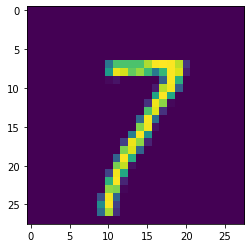

In [ ]:
#Define the dataset.
dataset = get_images_ready() 
#Get subset images and corresponding labels
X, Y = select_subset_images(dataset)

#View some random images
i = randint(0, X.shape[0])
print(i)
plt.imshow(np.squeeze(X[i]))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	
	in_lat = Input(shape=(latent_dim,)) #taking the noise as an input
	#Start with enough dense nodes to be reshaped and ConvTransposed to 28x28x1
	n_nodes = 256 * 7 * 7
	X = Dense(n_nodes)(in_lat)
	X = LeakyReLU(alpha=0.2)(X)
	X = Reshape((7, 7, 256))(X)
	
	X = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(X) #14x14x128
	X = LeakyReLU(alpha=0.2)(X)
	
	X = Conv2DTranspose(64, (3,3), strides=(1,1), padding='same')(X) #14x14x64
	X = LeakyReLU(alpha=0.2)(X)
	# output
	out_layer = Conv2DTranspose(1, (3,3), strides=(2,2), activation='tanh', 
                             padding='same')(X) #28x28x1   | Generating the output images
	# define model
	model = Model(in_lat, out_layer)
	return model


In [ ]:
gen_model=define_generator(100)
print(gen_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      295040    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                             

In [ ]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    in_image = Input(shape=in_shape)
    X = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Conv2D(64, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Flatten()(X)
    X = Dropout(0.4)(X) #Consider adding more dropout layers to minimize overfitting - remember we work with limited labeled data. 
    X = Dense(n_classes)(X)
    
    model = Model(inputs=in_image, outputs=X)
    
    return model

In [ ]:
def define_sup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Activation('softmax'))
    #Let us use sparse categorical loss so we dont have to convert our Y to categorical
    model.compile(optimizer=adam_v2.Adam(lr=0.0002, beta_1=0.5), 
                  loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    return model

In [ ]:
def custom_activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x /(Z_x+1)
    
    return D_x

#You can also try the built in tensorflow function: tf.reduce_logsumexp(class_logits, 1)

def define_unsup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Lambda(custom_activation))
    model.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(lr=0.0002, beta_1=0.5))
    return model

In [ ]:
def define_gan(gen_model, disc_unsup):
	
	disc_unsup.trainable = False # make unsup. discriminator not trainable
	gan_output = disc_unsup(gen_model.output) #Gen. output is the input to disc. 
	model = Model(gen_model.input, gan_output) #
	model.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(lr=0.0002, beta_1=0.5))
	return model


In [ ]:
def load_real_samples(n_classes=10):
    (trainX, trainy), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1] as we will be using tanh activation. 
    print(X.shape, trainy.shape)
    return [X, trainy]

In [ ]:
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
 	X, y = dataset
 	X_list, y_list = list(), list()
 	n_per_class = int(n_samples / n_classes) #Number of amples per class. 
 	for i in range(n_classes):
         X_with_class = X[y == i] # get all images for this class
         ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
         [X_list.append(X_with_class[j]) for j in ix] # add to list
         [y_list.append(i) for j in ix]
 	return asarray(X_list), asarray(y_list) #Returns a list of 2 numpy arrays corresponding to X and Y

In [ ]:
def generate_real_samples(dataset, n_samples):
    
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix] #Select random images and corresponding labels
	y = ones((n_samples, 1)) #Label all images as 1 as these are real images. (for the discriminator training) 
	return [X, labels], y


In [ ]:
def generate_latent_points(latent_dim, n_samples): #to generate random noise vector
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim) # reshape for input to the network
	return z_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	
	z_input = generate_latent_points(latent_dim, n_samples)
	fake_images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1)) #Label all images as 0 as these are fake images. (for the discriminator training) 
	return fake_images, y

In [ ]:
def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
	# Generate fake images
	X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
	
	X = (X + 1) / 2.0 # scale to [0,1] for plotting
	# plot images
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to drive
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
    
	# evaluate the discriminator 
	X, y = dataset
	_, acc = disc_sup.evaluate(X, y, verbose=0)
	print('Discriminator Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'gen_model_%04d.h5' % (step+1)
	gen_model.save(filename2)
	# save the Discriminator (classifier) model
	filename3 = 'disc_sup_%04d.h5' % (step+1)
	disc_sup.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [ ]:
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
	
    # select supervised dataset for training.
    #Remember that we are not using all 60k images, just a subset (100 images, 10 per class. )
	X_sup, y_sup = select_supervised_samples(dataset)
	#print(X_sup.shape, y_sup.shape)
	
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# iterations
	n_steps = bat_per_epo * n_epochs
	
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, 
                                                              n_batch, half_batch, 
                                                              bat_per_epo, n_steps))
	
    #  enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (disc_sup) on real samples.
        #Remember that we use real labels to train as this is supervised. 
        #This is the discriminator we really care about at the end.
        #Also, this is a multiclass classifier, not binary. Therefore, our y values 
        #will be the real class labels for MNIST. (NOT 1 or 0 indicating real or fake.)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)
        
		# update unsupervised discriminator (disc_unsup) - just like in our regular GAN.
        #Remember that we will not train on labels as this is unsupervised, just binary as in our regular GAN.
        #The y_real below indicates 1s telling the discriminator that these images are real. 
        #do not confuse this with class labels. 
        #We will discard this discriminator at the end. 
		[X_real, _], y_real = generate_real_samples(dataset, half_batch) #
		d_loss_real = disc_unsup.train_on_batch(X_real, y_real)
        #Now train on fake. 
		X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
		d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)
        
		# update generator (gen) - like we do in regular GAN.
        #We can discard this model at the end as our primary goal is to train a multiclass classifier (sup. disc.)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		gan_loss = gan_model.train_on_batch(X_gan, y_gan)
        
		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, sup_loss, sup_acc*100, d_loss_real, d_loss_fake, gan_loss))
		# evaluate the model performance periodically
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)


In [ ]:
# TRAIN

latent_dim = 100

#Create the discriminator models
disc=define_discriminator() #Bare discriminator model where last layer is dense(10 neurons) with no activation function, these weights are shared by both the supervised and unsupervised discriminator
disc_sup=define_sup_discriminator(disc) #Supervised discriminator model, has softmax activation in last layer & loss is sparse categorical crossentropy
disc_unsup=define_unsup_discriminator(disc) #Unsupervised discriminator model. 

gen_model = define_generator(latent_dim) #Generator
gan_model = define_gan(gen_model, disc_unsup) #GAN: takes generators output images as input
dataset = load_real_samples() #Define the dataset by loading real samples. (This will be a list of 2 numpy arrays, X and y)


# NOTE: 1 epoch = 600 steps in this example. 
train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=10, n_batch=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
n_epochs=10, n_batch=100, 1/2=50, b/e=600, steps=6000
>1, c[2.305,10], d[0.094,2.399], g[0.095]
>2, c[2.299,10], d[0.092,2.398], g[0.095]
>3, c[2.313,16], d[0.089,2.397], g[0.095]
>4, c[2.293,16], d[0.087,2.396], g[0.096]
>5, c[2.287,14], d[0.085,2.395], g[0.096]
>6, c[2.296,16], d[0.083,2.393], g[0.096]
>7, c[2.270,16], d[0.079,2.391], g[0.096]
>8, c[2.278,12], d[0.077,2.389], g[0.097]
>9, c[2.242,36], d[0.073,2.387], g[0.097]
>10, c[2.267,18], d[0.070,2.384], g[0.097]
>11, c[2.245,16], d[0.068,2.383], g[0.098]
>12, c[2.254,30], d[0.066,2.383], g[0.098]
>13, c[2.264,18], d[0.065,2.380], g[0.098]
>14, c[2.248,16], d[0.063,2.377], g[0.099]
>15, c[2.205,30], d[0.062,2.377], g[0.100]
>16, c[2.183,36], d[0.065,2.360], g[0.103]
>17, c[2.185,34], d[0.069,2.325], g[0.107]
>18, c[2.141,42], d[0.076,2.282], g[0.113]
>19, c[2.159,32], d[0.084,2.240], g[0.118]
>20, c[2.144,34], d[0.091,2.202], g[0.123]
>21, c[2.191,26], d[0.096,2.183], g[0.125]
>22, c[2.135,30], d[0.08

Discriminator Accuracy: 79.450%
>Saved: generated_plot_0600.png, gen_model_0600.h5, and disc_sup_0600.h5
>601, c[0.126,98], d[0.885,0.909], g[0.957]
>602, c[0.085,100], d[0.866,0.922], g[0.994]
>603, c[0.050,100], d[0.848,1.028], g[1.167]
>604, c[0.091,100], d[0.824,0.855], g[1.111]
>605, c[0.076,100], d[1.001,0.679], g[0.934]
>606, c[0.067,100], d[0.620,1.080], g[1.077]
>607, c[0.046,100], d[0.507,0.950], g[1.211]
>608, c[0.061,100], d[0.797,0.872], g[1.162]
>609, c[0.096,100], d[0.736,0.689], g[1.119]
>610, c[0.054,100], d[0.868,1.033], g[1.114]
>611, c[0.099,98], d[0.991,0.746], g[1.034]
>612, c[0.101,98], d[0.770,0.946], g[1.053]
>613, c[0.052,100], d[0.678,0.708], g[1.170]
>614, c[0.042,100], d[0.871,0.775], g[1.112]
>615, c[0.070,100], d[0.699,0.824], g[0.993]
>616, c[0.062,100], d[0.750,0.918], g[1.167]
>617, c[0.061,100], d[0.772,0.708], g[1.118]
>618, c[0.086,100], d[0.562,0.851], g[1.025]
>619, c[0.076,100], d[0.635,0.618], g[1.112]
>620, c[0.088,98], d[0.991,0.760], g[0.980]

Discriminator Accuracy: 88.108%
>Saved: generated_plot_1200.png, gen_model_1200.h5, and disc_sup_1200.h5
>1201, c[0.040,100], d[0.535,0.680], g[1.402]
>1202, c[0.025,100], d[0.955,0.896], g[1.407]
>1203, c[0.022,100], d[1.040,0.745], g[1.219]
>1204, c[0.038,100], d[0.769,0.681], g[1.262]
>1205, c[0.017,100], d[0.714,0.742], g[1.365]
>1206, c[0.029,100], d[0.531,0.615], g[1.305]
>1207, c[0.016,100], d[0.806,0.711], g[1.234]
>1208, c[0.026,100], d[0.860,0.975], g[1.230]
>1209, c[0.043,100], d[0.722,0.622], g[1.419]
>1210, c[0.013,100], d[0.791,0.619], g[1.386]
>1211, c[0.018,100], d[0.579,0.600], g[1.209]
>1212, c[0.029,100], d[0.722,0.769], g[1.251]
>1213, c[0.035,100], d[0.982,0.527], g[1.041]
>1214, c[0.021,100], d[0.840,0.499], g[1.132]
>1215, c[0.020,100], d[0.517,0.987], g[1.021]
>1216, c[0.027,100], d[0.784,0.647], g[1.160]
>1217, c[0.014,100], d[0.720,1.064], g[1.357]
>1218, c[0.027,100], d[0.709,0.821], g[1.360]
>1219, c[0.019,100], d[1.185,0.841], g[1.316]
>1220, c[0.026,100], 

Discriminator Accuracy: 88.943%
>Saved: generated_plot_1800.png, gen_model_1800.h5, and disc_sup_1800.h5
>1801, c[0.025,100], d[0.769,0.852], g[1.101]
>1802, c[0.015,100], d[0.915,0.779], g[1.068]
>1803, c[0.018,100], d[0.769,0.700], g[1.302]
>1804, c[0.029,98], d[0.735,0.729], g[1.232]
>1805, c[0.013,100], d[0.734,0.622], g[1.282]
>1806, c[0.014,100], d[0.636,0.818], g[1.249]
>1807, c[0.010,100], d[0.751,0.663], g[1.171]
>1808, c[0.022,100], d[0.812,0.762], g[1.296]
>1809, c[0.010,100], d[0.771,0.815], g[1.367]
>1810, c[0.019,100], d[0.631,0.618], g[1.388]
>1811, c[0.011,100], d[1.088,0.797], g[1.231]
>1812, c[0.021,100], d[0.693,0.708], g[1.354]
>1813, c[0.014,100], d[0.727,1.017], g[1.432]
>1814, c[0.024,100], d[0.748,0.811], g[1.204]
>1815, c[0.019,100], d[0.890,0.818], g[1.281]
>1816, c[0.024,100], d[0.796,0.761], g[1.273]
>1817, c[0.020,100], d[0.799,0.567], g[1.141]
>1818, c[0.012,100], d[0.777,0.725], g[0.977]
>1819, c[0.030,100], d[0.977,0.763], g[1.107]
>1820, c[0.008,100], d

Discriminator Accuracy: 91.035%
>Saved: generated_plot_2400.png, gen_model_2400.h5, and disc_sup_2400.h5
>2401, c[0.007,100], d[0.825,0.732], g[1.299]
>2402, c[0.007,100], d[1.004,0.810], g[1.107]
>2403, c[0.012,100], d[0.536,0.645], g[1.196]
>2404, c[0.012,100], d[0.804,0.765], g[1.107]
>2405, c[0.007,100], d[0.682,0.868], g[1.117]
>2406, c[0.014,100], d[0.834,0.809], g[1.080]
>2407, c[0.007,100], d[0.665,0.497], g[1.331]
>2408, c[0.008,100], d[0.554,0.902], g[1.098]
>2409, c[0.010,100], d[0.837,0.801], g[1.250]
>2410, c[0.010,100], d[0.602,0.824], g[1.312]
>2411, c[0.006,100], d[0.896,0.848], g[1.241]
>2412, c[0.009,100], d[0.792,0.960], g[1.277]
>2413, c[0.010,100], d[0.680,0.751], g[1.276]
>2414, c[0.009,100], d[0.884,0.843], g[1.251]
>2415, c[0.014,100], d[0.699,0.793], g[1.125]
>2416, c[0.015,100], d[0.630,0.700], g[1.225]
>2417, c[0.013,100], d[0.684,0.950], g[1.536]
>2418, c[0.006,100], d[0.736,0.580], g[1.358]
>2419, c[0.011,100], d[1.046,0.638], g[1.051]
>2420, c[0.022,100], 

Discriminator Accuracy: 92.375%
>Saved: generated_plot_3000.png, gen_model_3000.h5, and disc_sup_3000.h5
>3001, c[0.004,100], d[0.522,0.883], g[1.186]
>3002, c[0.009,100], d[0.783,0.931], g[1.361]
>3003, c[0.007,100], d[0.966,0.730], g[1.479]
>3004, c[0.003,100], d[0.847,0.699], g[1.304]
>3005, c[0.007,100], d[0.940,0.660], g[1.249]
>3006, c[0.005,100], d[0.634,0.699], g[1.143]
>3007, c[0.014,100], d[0.752,0.789], g[1.069]
>3008, c[0.005,100], d[0.729,0.738], g[1.181]
>3009, c[0.005,100], d[0.811,0.695], g[1.209]
>3010, c[0.006,100], d[0.770,0.759], g[1.178]
>3011, c[0.011,100], d[0.488,0.784], g[1.360]
>3012, c[0.006,100], d[0.714,0.536], g[1.459]
>3013, c[0.003,100], d[0.655,0.618], g[1.167]
>3014, c[0.005,100], d[0.821,0.761], g[1.049]
>3015, c[0.004,100], d[0.723,0.771], g[1.304]
>3016, c[0.008,100], d[0.988,0.832], g[1.288]
>3017, c[0.012,100], d[0.934,0.771], g[1.296]
>3018, c[0.005,100], d[1.038,0.692], g[1.258]
>3019, c[0.004,100], d[0.892,0.759], g[1.116]
>3020, c[0.008,100], 

Discriminator Accuracy: 92.592%
>Saved: generated_plot_3600.png, gen_model_3600.h5, and disc_sup_3600.h5
>3601, c[0.005,100], d[0.610,0.460], g[1.187]
>3602, c[0.005,100], d[0.537,0.935], g[1.111]
>3603, c[0.007,100], d[0.706,0.821], g[1.144]
>3604, c[0.007,100], d[0.615,1.095], g[1.293]
>3605, c[0.005,100], d[0.734,0.910], g[1.277]
>3606, c[0.008,100], d[0.845,0.636], g[1.291]
>3607, c[0.010,100], d[0.871,0.885], g[1.293]
>3608, c[0.008,100], d[0.761,0.644], g[1.223]
>3609, c[0.007,100], d[0.545,0.643], g[1.260]
>3610, c[0.007,100], d[0.729,0.620], g[1.411]
>3611, c[0.009,100], d[0.843,0.563], g[1.246]
>3612, c[0.013,100], d[0.901,0.831], g[1.213]
>3613, c[0.009,100], d[0.693,0.854], g[1.211]
>3614, c[0.004,100], d[0.803,0.868], g[1.315]
>3615, c[0.004,100], d[0.807,0.572], g[1.313]
>3616, c[0.007,100], d[0.803,0.780], g[1.239]
>3617, c[0.010,100], d[0.667,0.697], g[1.387]
>3618, c[0.008,100], d[0.618,0.991], g[1.140]
>3619, c[0.006,100], d[0.676,0.847], g[1.397]
>3620, c[0.014,100], 

Discriminator Accuracy: 93.275%
>Saved: generated_plot_4200.png, gen_model_4200.h5, and disc_sup_4200.h5
>4201, c[0.003,100], d[0.898,0.851], g[1.166]
>4202, c[0.004,100], d[0.772,0.702], g[1.067]
>4203, c[0.005,100], d[0.623,0.797], g[1.130]
>4204, c[0.004,100], d[0.831,0.811], g[1.252]
>4205, c[0.012,100], d[0.790,0.741], g[1.105]
>4206, c[0.005,100], d[0.658,0.899], g[1.219]
>4207, c[0.010,100], d[0.717,0.917], g[1.308]
>4208, c[0.006,100], d[0.759,0.760], g[1.047]
>4209, c[0.005,100], d[0.921,0.978], g[1.110]
>4210, c[0.006,100], d[0.632,0.638], g[1.223]
>4211, c[0.017,100], d[0.661,0.807], g[1.310]
>4212, c[0.004,100], d[0.791,0.845], g[1.177]
>4213, c[0.007,100], d[0.860,0.812], g[1.360]
>4214, c[0.006,100], d[0.667,1.076], g[1.328]
>4215, c[0.005,100], d[0.810,0.706], g[1.308]
>4216, c[0.010,100], d[0.773,0.814], g[1.317]
>4217, c[0.003,100], d[0.789,0.844], g[1.232]
>4218, c[0.002,100], d[0.853,0.723], g[1.197]
>4219, c[0.003,100], d[0.710,0.658], g[1.114]
>4220, c[0.007,100], 

Discriminator Accuracy: 93.123%
>Saved: generated_plot_4800.png, gen_model_4800.h5, and disc_sup_4800.h5
>4801, c[0.003,100], d[0.751,0.740], g[1.182]
>4802, c[0.005,100], d[0.734,0.682], g[1.191]
>4803, c[0.004,100], d[0.604,0.738], g[1.350]
>4804, c[0.009,100], d[0.748,0.689], g[1.379]
>4805, c[0.002,100], d[0.796,0.863], g[1.286]
>4806, c[0.003,100], d[0.801,0.655], g[1.299]
>4807, c[0.002,100], d[0.904,0.864], g[1.248]
>4808, c[0.002,100], d[0.663,0.551], g[1.103]
>4809, c[0.003,100], d[0.695,1.003], g[1.219]
>4810, c[0.004,100], d[0.527,0.648], g[1.144]
>4811, c[0.007,100], d[0.782,0.637], g[1.044]
>4812, c[0.003,100], d[0.865,0.860], g[1.105]
>4813, c[0.006,100], d[0.681,0.845], g[1.250]
>4814, c[0.002,100], d[0.889,0.955], g[1.130]
>4815, c[0.006,100], d[0.875,0.769], g[1.222]
>4816, c[0.005,100], d[0.751,0.858], g[1.221]
>4817, c[0.010,100], d[0.636,0.696], g[1.162]
>4818, c[0.003,100], d[0.773,0.791], g[1.051]
>4819, c[0.005,100], d[0.834,0.724], g[1.140]
>4820, c[0.005,100], 

Discriminator Accuracy: 93.437%
>Saved: generated_plot_5400.png, gen_model_5400.h5, and disc_sup_5400.h5
>5401, c[0.004,100], d[0.875,0.810], g[1.104]
>5402, c[0.003,100], d[0.848,0.892], g[1.179]
>5403, c[0.007,100], d[0.827,0.757], g[1.027]
>5404, c[0.004,100], d[0.663,0.761], g[1.043]
>5405, c[0.004,100], d[0.542,0.915], g[1.119]
>5406, c[0.002,100], d[0.902,0.948], g[1.291]
>5407, c[0.005,100], d[0.670,0.697], g[1.210]
>5408, c[0.002,100], d[0.913,0.988], g[1.147]
>5409, c[0.003,100], d[0.779,0.817], g[1.151]
>5410, c[0.006,100], d[0.710,0.759], g[1.298]
>5411, c[0.012,100], d[1.010,0.659], g[1.019]
>5412, c[0.003,100], d[0.884,0.852], g[1.269]
>5413, c[0.004,100], d[0.763,0.769], g[1.122]
>5414, c[0.006,100], d[0.703,0.687], g[1.108]
>5415, c[0.003,100], d[0.681,1.054], g[1.121]
>5416, c[0.006,100], d[0.816,0.659], g[1.010]
>5417, c[0.002,100], d[0.544,1.108], g[1.090]
>5418, c[0.003,100], d[0.636,0.970], g[1.355]
>5419, c[0.002,100], d[0.995,0.990], g[1.213]
>5420, c[0.003,100], 

Discriminator Accuracy: 93.892%
>Saved: generated_plot_6000.png, gen_model_6000.h5, and disc_sup_6000.h5


In [ ]:
#############################################################################
#EVALUATE THE SUPERVISED DISCRIMINATOR ON TEST DATA
# This is the model we want as a classifier. 
##################################################################
from keras.models import load_model
# load the model
disc_sup_trained_model = load_model('disc_sup_6000.h5')

# load the dataset
(_, _), (testX, testy) = load_data()

# expand to 3d, e.g. add channels
testX = expand_dims(testX, axis=-1)

# convert from ints to floats
testX = testX.astype('float32')

# scale from [0,255] to [-1,1]
testX = (testX - 127.5) / 127.5

# evaluate the model
_, test_acc = disc_sup_trained_model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

# Predicting the Test set results
y_pred_test = disc_sup_trained_model.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)

Test Accuracy: 94.400%


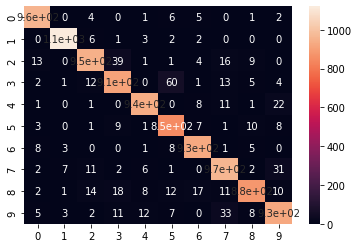

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(testy, prediction_test)
sns.heatmap(cm, annot=True)


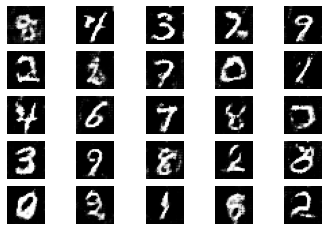

In [ ]:
#############################################################################
#PREDICT / GENERATE IMAGES using the generator, just for fun.
##################################################################

# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(np.squeeze(examples[i, :, :, :]), cmap='gray')
	plt.show()

# load model
gen_trained_model = load_model('gen_model_6000.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = gen_trained_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)